In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
import numpy as np

# Loading Model and Cascade Classifier

In [2]:
car_classifier = cv2.CascadeClassifier("haarcascade_car.xml");
nameplate_classifier= cv2.CascadeClassifier("indian_license_plate.xml")
character_recognizer = load_model('AlphaNumericCharacterRecognition30x30 (1).h5')

# Extracting Nameplate from the Car Image 

In [3]:
def nameplate_extractor(image):
    frame = image.copy()
    #Converting image from BGR to GRAY
    nameplates = []
    #Load classifier for nameplate detection
    nameplate_classifier= cv2.CascadeClassifier("indian_license_plate.xml")
    detected_nameplates = nameplate_classifier.detectMultiScale(frame, scaleFactor=1.3, minNeighbors=7)
    #Rescaling Image
    y_scale, x_scale = (int(0.020*frame.shape[0]),int(0.012*frame.shape[1]))
    for x,y,w,h in detected_nameplates:
        nameplates.append(image[y+y_scale:y+h, x+x_scale:x+w])  
        cv2.rectangle(frame, (x,y), (x+w,y+h), color=(0,255,0), thickness=2)
    
    return nameplates, frame

# Finding Largest Contours --> Characters

In [4]:
def findContours(image, validDimensions):
    #Converting grayscale image to binary image
    binary_img = image.copy()

    #Identifing contours and considering the largest 15 countours for character recognition
    contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE,)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:20]
    
    y_lower, y_upper, x_lower,x_upper = validDimensions
    start_indices = []
    cntr_width = []
    character_images = []
    
    for contour in contours:
        x,y,width,height = cv2.boundingRect(contour)

        #Check if width and height of character is in valid character dimensions
        if width>y_lower and width < y_upper and height > x_lower and height < x_upper:
            
            cv2.rectangle(binary_img, (x,y),(x+width,y+height), color=(204), thickness=2)
            #Adding start of each character 
            start_indices.append(x)
            cntr_width.append(width)
            charImg = image[y-2:y+height+2,x-2:x+width+2]
            charImg = cv2.resize(charImg,(26,46))
            charImg_ = ~(charImg)
            charImg_ = np.ones((50,30))
            charImg_[2:48,2:28] = charImg
            charImg_[0:2,:] = 0
            charImg_[:,0:2] = 0
            charImg_[-3:,:] = 0
            charImg_[:,-3:] = 0
            
            
            #Appending all the character images. Note characters are not in order
            character_images.append(charImg_)        
    #Storing image with detected characters
    cv2.imwrite("DetectedCharacters.jpg",binary_img)
    
    #Sort the characters based on start indices i.e x --> gives correct order of characters from L2R
    character_sorted = []
    cntr_width_sorted = []
    start_indices_sorted = []
    indices = sorted(range(len(start_indices)), key= lambda i: start_indices[i])[:15]
    for i in indices:
        character_sorted.append(character_images[i])
        cntr_width_sorted.append(cntr_width[i])
        start_indices_sorted.append(start_indices[i])
    
    
    #Checking for contours between same [x:x+width] 
    #Removing smaller contour image which comes under same bounding rectangle
    start = 0
    image_result = []
    
    for i,ch in enumerate(character_sorted):
        
        if start_indices_sorted[i] >= start:
            image_result.append(ch)
            start = start_indices_sorted[i]+cntr_width_sorted[i]-10
        
    image_result = np.array(image_result)
    return image_result
    


In [5]:
def imageSegementation(images):
    character_list_final = []
    for image in images:
        character_list_final = []
        img = image.copy()
        img = cv2.resize(img,(320,80))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        threshold, image_binary = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        image_binary = cv2.erode(image_binary,(3,3))
        image_binary = cv2.dilate(image_binary,(3,3))
        width, height = image_binary.shape[0], image_binary.shape[1]
        #Taking estimated character size for determining useful contours
        character_dimentions = (int(width/8), int(width/2), int(height/10), int(9*height/10))
        #Colouring border
        image_binary[0:3,:] = 0
        image_binary[:,0:3] = 0
        image_binary[-3:,:] = 0
        image_binary[:,-3:] = 0
        character_list_final = findContours(image_binary, character_dimentions)
        print(len(character_list_final))
        
        
    return character_list_final
    
    
    

# Capturing the Images from Live Stream

In [ ]:
cap = cv2.VideoCapture(0)
plate_imgs = []
plates = []
while cap.isOpened():
    #time.sleep(0.5)
    ret, frame = cap.read()
    if ret:
        cars = car_classifier.detectMultiScale(frame ,1.3, 7)
        for (x,y,w,h) in cars:
            car = frame[y:y+h,x:x+w]
            cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,255), 2)
            cv2.imshow("Cars", frame)
            plate, plate_img = nameplate_extractor(car)
            if plate is None:
                continue
            plates.append(plate)
            plate_imgs.append(plate_img)
        if cv2.waitKey(1) == 13:
            cv2.destroyAllWindows()
            break
cap.release()

for i,plate in enumerate(plates):
    cv2.imshow("Detected Plates", plate_imgs[i])
    characters = imageSegementation(plate)
    if len(characters) != 0:
        cv2.imshow("License Plate", plate)
    if cv2.waitKey(50) == 13:
        cv2.destroyAllWindows()
        break
        
    

# Recognizing Characters using CNN

In [6]:
#LABELS --> dictionary for classes recognized by model
LABELS = {}
for i in range(0,10):
    LABELS[i] = str(i)
for i in range(65,91):
    LABELS[i-55] = chr(i)

#Fixing the dimension of image as required by model here model takes image of dimension (30,30,3) 
def fix_dimension(img): 
    new_img = np.zeros((30,30,3))
    for i in range(3):
        new_img[:,:,i] = img
    return new_img


def recognizeCharacters(charactersList):
    plate_number = ""
    
    for i,ch in enumerate(charactersList):
    
        ch_ = cv2.resize(ch, (30,30))
        ch_final = fix_dimension(ch_)
        ch_final = ch_final.reshape(1,30,30,3)
        predicted_class = character_recognizer.predict_classes(ch_final)
        plate_number += LABELS[predicted_class[0]]
    return plate_number       

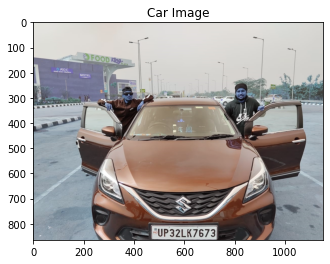

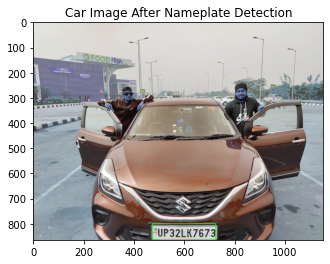

10


C:\Users\chaud\AppData\Roaming\Python\Python38\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [7]:
frame = cv2.imread("cars.jpeg")
plt.imshow(frame)
plt.title("Car Image")
plt.show()
plate, image = nameplate_extractor(frame)
plt.imshow(image)
plt.title("Car Image After Nameplate Detection")
plt.show()
character_list_final = imageSegementation(plate)
plate_num = recognizeCharacters(character_list_final)



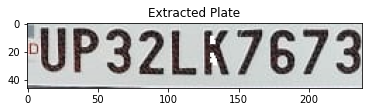

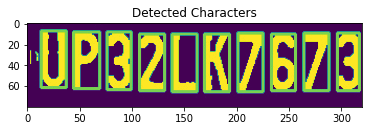

In [8]:
plt.imshow(plate[0])
plt.title("Extracted Plate")
plt.show()

plt.imshow(plt.imread("DetectedCharacters.jpg"))
plt.title("Detected Characters")
plt.show()

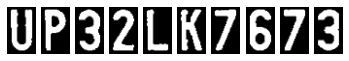

In [9]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(character_list_final[i], cmap='gray')
    plt.axis('off')

PLATE NUMBER : UP32LK7673


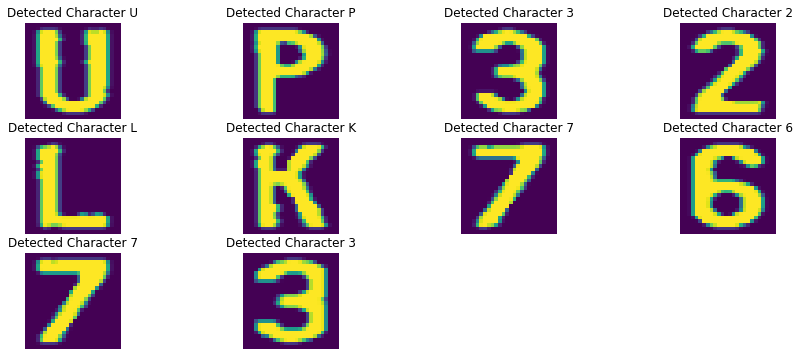

In [10]:
print(f'PLATE NUMBER : {plate_num}')
plt.figure(figsize=(15,6))
for i,ch in enumerate(character_list_final):
    img = cv2.resize(ch, (26,26))
    plt.subplot(3,4,i+1,)
    plt.imshow(img)
    plt.title(f'Detected Character: {plate_num[i]}')
    plt.axis('off')

# Getting information about Vehicle via API

In [11]:
import requests
import json
import xmltodict

def get_vehicle_info(plate_number):
    req = requests.get("https://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={}&username=Aditi".format(str(plate_number)))
    print(req)
    data = xmltodict.parse(r.content)
    jsonData = json.dumps(data)
    formatted_data = json.loads(jsonData)
    formatted_data_ = json.loads(formatted_data['Vehicle']['vehicleJson'])
    return formatted_data_

In [12]:
get_vehicle_info(plate_num)

<Response [200]>


{'Description': 'MARUTI SUZUKI BALENO DELTA PETROL',
 'RegistrationYear': '2020',
 'CarMake': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'CarModel': {'CurrentTextValue': 'BALENO DELTA PETROL'},
 'Variant': 'Delta 1.2 Petrol 1197.0',
 'EngineSize': {'CurrentTextValue': '1197.0'},
 'MakeDescription': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'ModelDescription': {'CurrentTextValue': 'BALENO DELTA PETROL'},
 'NumberOfSeats': {'CurrentTextValue': '5'},
 'VechileIdentificationNumber': 'MBHEWB22SLB449580',
 'EngineNumber': 'K12MN4654535',
 'FuelType': {'CurrentTextValue': 'PETROL'},
 'RegistrationDate': '20/03/2020',
 'Owner': 'DIPENDRA NATH',
 'Fitness': '',
 'Insurance': '2023-03-06',
 'PUCC': '',
 'VehicleType': 'MOTOR CAR(LMV)',
 'Location': 'Sitapur',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@TUFSVVRJIFNVWlVLSSBCQUxFTk8gREVMVEEgUEVUUk9M'}